In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from math import radians
from openpyxl import load_workbook

# Uncomment if you have installed matplotlib into Jupyter
# %matplotlib widget


The 'Ovni 445.xml' file is not present. You can download this file from mytimezero.


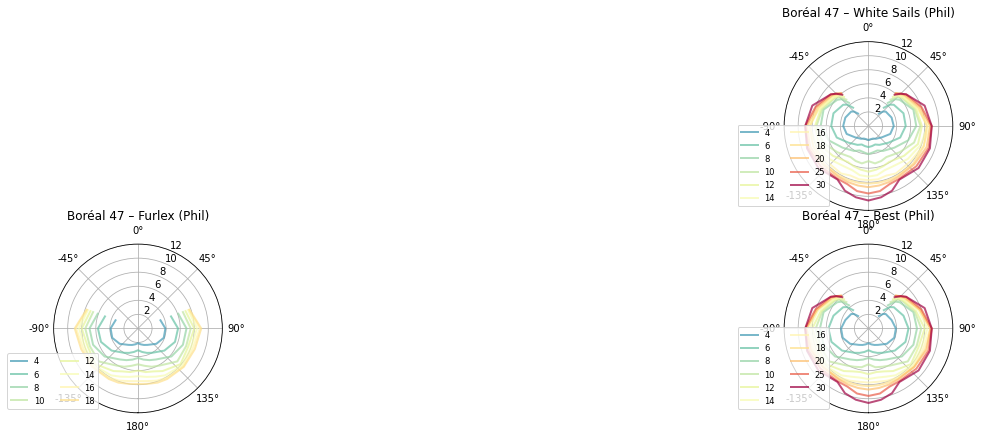

In [2]:
class PolarCurve:
    def __init__(self, wind, portValues, portDegrees):
        self.wind = int(wind)
        self.values = portValues + portValues[-2::-1]
        self.degrees = portDegrees + [360 - d for d in portDegrees[-2::-1]]
        
        self.radians = [radians(d) for d in self.degrees]
        
    def portTack(self):
        return [x for x in zip(self.degrees, self.values) if x[0] <= 180]
        
    def __repr__(self):
        return f"PC {self.wind} {self.degrees} {self.values}"

#
# Functions to read and write data in TimeZero XML format.
#
def read_tz(filename):
    def value(element, tagName):
        return float(element.find(tagName).attrib["value"])
        
    return [PolarCurve(
                value(polarCurve, "PolarCurveIndex"),
                [value(i, "Value") for i in polarCurve.findall("PolarItem")],
                [value(i, "Angle") for i in polarCurve.findall("PolarItem")])
            for polarCurve in ET.parse(filename).getroot()]

def write_tz(name, filename, curves):
    def value(n):
        return { 'value' : str(n) }
    
    polar = ET.Element('Polar')
    polar.text = name
    for c in curves:
        curve = ET.SubElement(polar, 'PolarCurve')
        ET.SubElement(curve, 'PolarCurveIndex', value(c.wind))
        for a, v in c.portTack():
            if v:
                item = ET.SubElement(curve, 'PolarItem')
                ET.SubElement(item, 'Angle', value(a))
                ET.SubElement(item, 'Value', value(v))

    ET.ElementTree(polar).write(
        filename,
        encoding="unicode",
        xml_declaration=True)

#
# Function to write data in PredictWind .txt format.
# https://help.predictwind.com/en/articles/4537527-importing-a-polar
# https://help.predictwind.com/en/articles/2884506-how-to-set-up-boat-polars-all-platforms
#
def write_pw(filename, curves):
    def value(n):
        return { 'value' : str(n) }
    
    file = open(filename, "w")
    for c in curves:
        file.write(f"{c.wind}\t0\t0\t" \
               + '\t'.join([f"{a}\t{v or 0}" for (a, v) in c.portTack()]) \
               + '\n')
    file.close()
    
#                                            
# Parse 'Ovni 445.xml' file, if present.
#
try:
    tzcurves = read_tz('Ovni 445.xml')
except FileNotFoundError:
    tzcurves = None
    print("The 'Ovni 445.xml' file is not present. You can download this file from mytimezero.")

#
# Parse Robert's data
#
def xlsPolarCurves(sheet):
    """Parse a single sheet from Robert's Excel spreadsheet."""
    degrees = [v[0].value for v in sheet['A2:A14']]

    # Uncomment for debug
    # print(sheet, degrees, [cells[0].value for cells in list(sheet.columns)[1:]])

    return [PolarCurve(cells[0].value, [c.value for c in cells[1:]], degrees)
            for cells in list(sheet.columns)[1:]]

robert = dict([(sheet.title, xlsPolarCurves(sheet))
               for sheet in load_workbook("Boreal 47 polars.xlsx") if sheet.title != "Plotting data"])

phil = dict([(sheet.title, xlsPolarCurves(sheet))
               for sheet in load_workbook("Boreal 47 phil.xlsx") if sheet.title in ["White Sails", "+Furlex", "Combined"]])

# Write out the "Combined" data in TimeZero format.
write_tz("Boréal 47", "Boreal47_timezero.xml", phil["Combined"])

# Write out the "Combined" data in PredictWind format.
write_pw("Boreal47_predictwind.txt", phil["Combined"])

#
# Render the polars.
#
f = plt.figure(figsize=(24,18))

def draw(ax, title, curves):
    ax.set_title(title)
    ax.set_theta_zero_location("N")
    ax.set_thetalim(thetamin=-180, thetamax=180)
    ax.set_theta_direction(-1)
    ax.set_xticks([radians(d) for d in [-135, -90, -45, 0, 45, 90, 135, 180]])
    ax.set_ylim(top=12)
    cmap = plt.colormaps.get_cmap('Spectral')
    for c in curves:
        ax.plot(c.radians, c.values, lw=2, label=c.wind, alpha=0.7, color=cmap(1-c.wind/30))

    ax.legend(loc="lower left", bbox_to_anchor=(-0.3, 0), ncol=2, fontsize="small")

#draw(plt.subplot(521, polar=True), "Boréal 47 – Best (Robert)", robert["Best"])
if tzcurves: draw(plt.subplot(522, polar=True), "Ovni 445 (Time Zero)", tzcurves)
#draw(plt.subplot(523, polar=True), "Boréal 47 – Main & Jib (Robert)", robert["main & jib only"])
#draw(plt.subplot(524, polar=True), "Boréal 47 – Spinnaker (Robert)", robert["+ Spinaker"])
#draw(plt.subplot(525, polar=True), "Boréal 47 – Asymmetric (Robert)", robert["+ Asymetric"])
draw(plt.subplot(526, polar=True), "Boréal 47 – White Sails (Phil)", phil["White Sails"])
draw(plt.subplot(527, polar=True), "Boréal 47 – Furlex (Phil)", phil["+Furlex"])
draw(plt.subplot(528, polar=True), "Boréal 47 – Best (Phil)", phil["Combined"])
  
# Save the rendered figure as a PDF.
f.savefig("Boreal47_polars.pdf", bbox_inches='tight')
